In [1]:
import os
import uproot as ur
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.optimize import curve_fit
import torch
from torch import nn

/home/dmisra/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
paths = []

for (path, dirnames, filenames) in os.walk('/mnt/scratch3/dmisra/zdcdata_current/'):
    paths.extend(os.path.join(path, name) for name in filenames)

In [3]:
samples = {}

for path in paths:
    with ur.open(path) as file:
       tree = file["events"]
       samples[os.path.basename(f'{path}')] = tree.arrays()

In [4]:
def bitExtract(n, k, p):  
    return (((1 << k) - 1)  &  (n >> (p-1)))

Total Energy Deposition in All ZDC Components

In [5]:
def components_edep(data, count):
    SiPix_edep = []
    Crystal_edep = []
    WSi_edep = []
    PbSi_edep = []
    PbScint_edep = []
    energylabels = []
    
    for i in range(count):
        SiPix_energies = np.array(data["ZDC_SiliconPix_Hits.energy"][i])
        SiPix_edep.append(sum(SiPix_energies))

        Crystal_energies = np.array(data["ZDCEcalHits.energy"][i])
        Crystal_edep.append(sum(Crystal_energies))

        WSi_energies = np.array(data["ZDC_WSi_Hits.energy"][i])
        WSi_edep.append(sum(WSi_energies))

        PbSi_energies = np.array(data["ZDC_PbSi_Hits.energy"][i])
        PbSi_edep.append(sum(PbSi_energies))

        PbScint_energies = np.array(data["ZDCHcalHits.energy"][i])
        PbScint_edep.append(sum(PbScint_energies))

        label = np.sqrt(data["MCParticles.momentum.x"][0,0]**2 + data["MCParticles.momentum.y"][0,0]**2 + data["MCParticles.momentum.z"][0,0]**2)
        energylabels.append(label)

    return pd.DataFrame([SiPix_edep, Crystal_edep, WSi_edep, PbSi_edep, PbScint_edep, energylabels])

In [6]:
#Data for linear regression
data = [components_edep(samples[key],10000) for key in samples]
data_df = pd.concat(data,axis=1)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
torch.manual_seed(42)

Linear Regression

In [8]:
data_tensor_10GeV = torch.from_numpy(data[3].values).T.float()
data_tensor_50GeV = torch.from_numpy(data[0].values).T.float()
data_tensor_100GeV = torch.from_numpy(data[1].values).T.float()
data_tensor_200GeV = torch.from_numpy(data[2].values).T.float()

In [9]:
data_tensor = torch.from_numpy(data_df.values).T.float()

In [10]:
def features(tensor):
    return tensor[:,:5]

def labels(tensor):
    return tensor[:,5].unsqueeze(dim=1)

In [11]:
x = features(data_tensor)
y = labels(data_tensor)

In [12]:
#Split train/test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

input_size = 5
output_size = 1

In [13]:
class LinearRegression(nn.Module):
    def __init__(self,input_size,output_size):
        super(LinearRegression,self).__init__()
        self.linear = nn.Linear(input_size,output_size)

    def forward(self,x):
        out = self.linear(x) 
        return out

In [17]:
model_0 = LinearRegression(input_size,output_size)

In [15]:
for layer in model_0.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.fill_(1)
         layer.bias.data.fill_(0)

In [18]:
learning_rate = 0.005
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr=learning_rate)

In [19]:
#Set number of epochs
epochs = 500000

#Create lists to track loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ###Training
    model_0.train()
    y_pred = model_0(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ###Testing
    model_0.eval()

    with torch.inference_mode():
        test_pred = model_0(x_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}")


Epoch: 0 | MSE Train Loss: 12972.11328125 | MSE Test Loss: 11719.4755859375
Epoch: 100 | MSE Train Loss: 3227.372802734375 | MSE Test Loss: 3177.5615234375
Epoch: 200 | MSE Train Loss: 2208.994384765625 | MSE Test Loss: 2204.013671875
Epoch: 300 | MSE Train Loss: 1913.6846923828125 | MSE Test Loss: 1921.810302734375
Epoch: 400 | MSE Train Loss: 1734.6279296875 | MSE Test Loss: 1748.1256103515625
Epoch: 500 | MSE Train Loss: 1596.8577880859375 | MSE Test Loss: 1613.15771484375
Epoch: 600 | MSE Train Loss: 1484.8660888671875 | MSE Test Loss: 1502.8677978515625
Epoch: 700 | MSE Train Loss: 1391.8262939453125 | MSE Test Loss: 1410.9361572265625
Epoch: 800 | MSE Train Loss: 1313.3978271484375 | MSE Test Loss: 1333.2313232421875
Epoch: 900 | MSE Train Loss: 1246.5269775390625 | MSE Test Loss: 1266.80810546875
Epoch: 1000 | MSE Train Loss: 1188.9749755859375 | MSE Test Loss: 1209.4964599609375
Epoch: 1100 | MSE Train Loss: 1139.05126953125 | MSE Test Loss: 1159.656005859375
Epoch: 1200 | MSE 

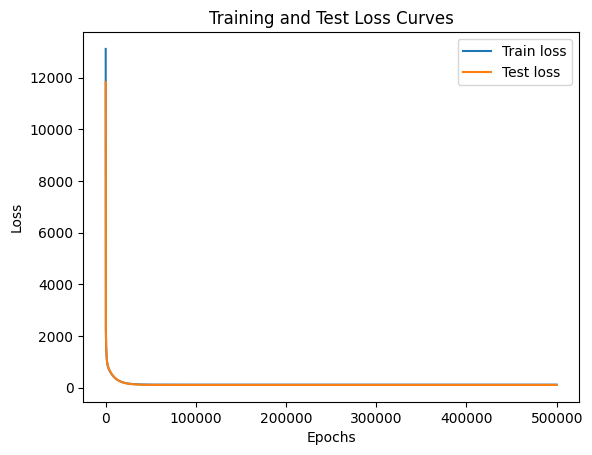

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
# Find the model's learned parameters
print(model_0.state_dict())

OrderedDict([('linear.weight', tensor([[  2.1829,   1.1574, 100.5793, 401.0872,  60.2897]])), ('linear.bias', tensor([2.8002]))])


Predictions

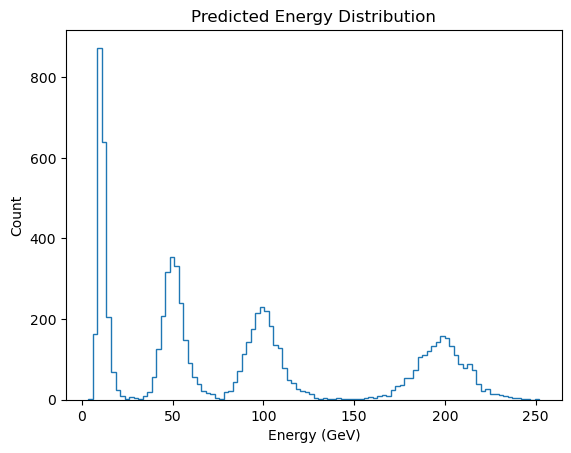

In [20]:
#Set the model in evaluation mode
model_0.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_0(x_test)

plt.hist(y_preds[:,0].numpy(),100,histtype='step')
plt.xlabel('Energy (GeV)')
plt.ylabel('Count')
plt.title('Predicted Energy Distribution')
plt.savefig("linregdist.pdf")

In [21]:
#Set the model in evaluation mode
model_0.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds_200GeV = model_0(features(data_tensor_200GeV))
  y_preds_100GeV = model_0(features(data_tensor_100GeV))
  y_preds_50GeV = model_0(features(data_tensor_50GeV))
  y_preds_10GeV = model_0(features(data_tensor_10GeV))

In [22]:
peak_preds = norm.fit(y_preds_10GeV)[0], norm.fit(y_preds_50GeV)[0], norm.fit(y_preds_100GeV)[0], norm.fit(y_preds_200GeV)[0]
true_peaks = [10,50,100,200]
peak_preds

(11.523889, 51.044907, 100.06893, 197.53485)

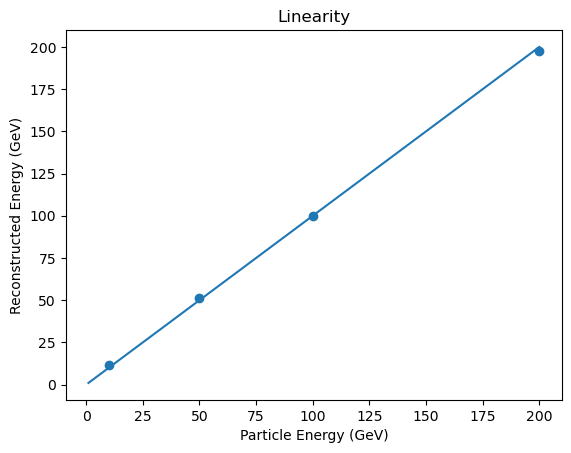

In [23]:
plt.scatter(true_peaks,peak_preds)
plt.xlabel('Particle Energy (GeV)')
plt.ylabel('Reconstructed Energy (GeV)')
plt.plot(np.arange(1,201),np.arange(1,201))
plt.title('Linearity')
plt.savefig("linreg_linearity.pdf")

In [24]:
#Get energy resolution from distribution of predictions
def res(preds,energy):
    return norm.fit(preds)[1]/energy

energy_list = [200,100,50,10]
resolutions = res(y_preds_200GeV,200), res(y_preds_100GeV,100), res(y_preds_50GeV,50), res(y_preds_10GeV,10)

In [25]:
#Curve fit for energy resolution as a function of energy
def f(E,a):
    return a/np.sqrt(E)

popt, pcov = curve_fit(f, energy_list, resolutions)

In [ ]:
#Include gaussian fit in loss fn

popt, pcov

(array([0.94902746]), array([[0.00073691]]))

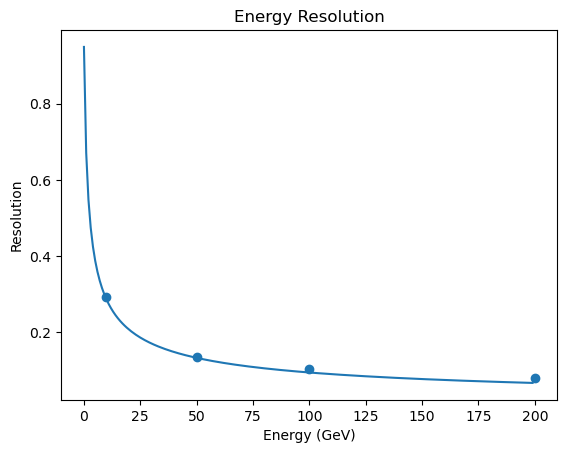

In [26]:
plt.plot(range(200),f(range(1,201),popt[0]))
plt.scatter(energy_list,resolutions)
plt.xlabel('Energy (GeV)')
plt.ylabel('Resolution')
plt.title('Energy Resolution')
plt.savefig("linreg_res.pdf")

In [92]:
torch.save(obj=model_0.state_dict, f="/home/dmisra/eic/model_0")